# chapter6 게이트가 추가된 RNN

## 6.1 RNN의 문제점

### 6.1.1 RNN 복습
- RNN 특징: $h_t$, 즉 은닉상태를 이용하여 과거 정보를 계승

### 6.1.2 기울기 소실 또는 기울기 폭발
- 기울기는 원래대로라면 학습해야 할 의미가 있는 정보가 들어있고, 그것을 과거로 전달함으로써 장기 의존 관계 학습
- 하지만 만약 기울기가 중간에 사그라들어 거의 아무런 정보도 남지 않게 되면 가중치 매개변수는 전혀 갱신하지 않게 된다
- 즉 장기 의존 관계를 학습할 수 없게 된다
- 현재의 단순한 RNN 계층에서는 시간을 거슬로 올라갈수록 기울기가 작아지거나 혹은 커질 수 있다 (기울기 소실, 폭발)

### 6.1.3 기울기 소실과 기울기 폭발의 원인

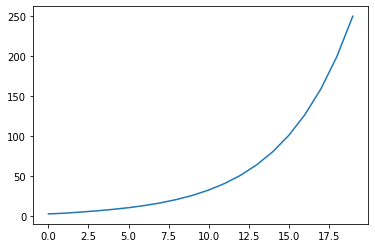

기울기 폭발: 기울기 dh는 시간 크기에 비례하여 지수적으로 증가한다


In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(norm_list)
plt.show()

print("기울기 폭발: 기울기 dh는 시간 크기에 비례하여 지수적으로 증가한다")

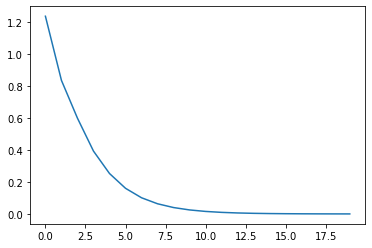

기울기 소실: 기울기 dh는 시간 크기에 비례하여 지수적으로 감소한다


In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(norm_list)
plt.show()

print("기울기 소실: 기울기 dh는 시간 크기에 비례하여 지수적으로 감소한다")

### 6.1.4 기울기 폭발 대책
- 기울기 클리핑 gradients clipping
- threshold를 문턱값으로 설정해, 기울기(신경망에서 사용되는 모든 매개변수의 기울기)의 L2 노름이 문턱값을 초과하면 기울기 수정

In [3]:
import numpy as np

dW1 = np.random.rand(3,3)*10
dW2 = np.random.rand(3,3)*10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm) + 1e-6
    if rate < 1:
        for grad in grads:
            grad *= rate

## 6.2 기울기 소실과 LSTM

### 6.2.1 LSTM의 인터페이스

### 6.2.2 LSTM 계층 조립하기
- LSTM에는 기억셀 $c_t$ 존재
- $c_t$에는 시각 t에서의 LSTM의 기억이 저장돼 있는데, 과거로부터 시각 t까지에 필요한 모든 정보가 저장돼 있다고 가정
- $h_t=tanh(c_t)$  :  갱신된 $c_t$를 사용해 은닉 상태 $h_t$ 계산

### 6.2.3 output 게이트
- $tanh(c_t)$의 각 원소에 대해 '그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정
- output게이트: 다음 은닉 상태 $h_t$의 출력을 담당

$o=σ(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$

$h_t=o⊙tanh(c_t)$

### 6.2.4 forget 게이트
- 무엇을 잊을까를 명확하게 지시 ($c_{t-1}$의 기억 중에서 불필요한 기억 잊게 해주는 게이트 추가)

$f=σ(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$

$c_t=f⊙c_{t-1}$

### 6.2.5 새로운 기억 셀
- 새로운 정보를 기억 셀에 추가

$g=σ(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})$

### 6.2.6 input 게이트
- g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지 판단

$i=σ(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$

### 6.2.7 LSTM의 기울기 흐름

## 6.3 LSTM 구현

In [4]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # 4개분의 가중치가 담김 
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # 순전파 때 중간 결과를 보관했다가 역전파 계산에 이용

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### 6.3.1 Time LSTM 구현

In [5]:
class TimeLSTM:
    # T 개분의 시계열 데이터를 한꺼번에 처리
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad # LSTM 레이어는 같은 가중치 사용하므로

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 10[s] | perplexity 2965.95
| epoch 1 |  iter 41 / 1327 | time 20[s] | perplexity 1247.29
| epoch 1 |  iter 61 / 1327 | time 30[s] | perplexity 969.02
| epoch 1 |  iter 81 / 1327 | time 40[s] | perplexity 783.35
| epoch 1 |  iter 101 / 1327 | time 50[s] | perplexity 653.61
| epoch 1 |  iter 121 / 1327 | time 59[s] | perplexity 641.88
| epoch 1 |  iter 141 / 1327 | time 68[s] | perplexity 600.89
| epoch 1 |  iter 161 / 1327 | time 76[s] | perplexity 579.60
| epoch 1 |  iter 181 / 1327 | time 86[s] | perplexity 579.73
| epoch 1 |  iter 201 / 1327 | time 96[s] | perplexity 502.86
| epoch 1 |  iter 221 / 1327 | time 106[s] | perplexity 502.25
| epoch 1 |  iter 241 / 1327 | time 117[s] | perplexity 456.13
| epoch 1 |  iter 261 / 1327 | time 127[s] | perplexity 470.11
| epoch 1 |  iter 281 / 1327 | time 137[s] | perplexity 461.30
| epoch 1 |  iter 301 / 1327 | time 146[s] | perplexity 392.89
| epoch

| epoch 2 |  iter 1261 / 1327 | time 1262[s] | perplexity 124.02
| epoch 2 |  iter 1281 / 1327 | time 1272[s] | perplexity 121.79
| epoch 2 |  iter 1301 / 1327 | time 1282[s] | perplexity 156.72
| epoch 2 |  iter 1321 / 1327 | time 1292[s] | perplexity 152.07
| epoch 3 |  iter 1 / 1327 | time 1296[s] | perplexity 160.76
| epoch 3 |  iter 21 / 1327 | time 1306[s] | perplexity 143.65
| epoch 3 |  iter 41 / 1327 | time 1316[s] | perplexity 135.01
| epoch 3 |  iter 61 / 1327 | time 1326[s] | perplexity 126.05
| epoch 3 |  iter 81 / 1327 | time 1336[s] | perplexity 117.07
| epoch 3 |  iter 101 / 1327 | time 1346[s] | perplexity 105.47
| epoch 3 |  iter 121 / 1327 | time 1356[s] | perplexity 115.72
| epoch 3 |  iter 141 / 1327 | time 1366[s] | perplexity 125.05
| epoch 3 |  iter 161 / 1327 | time 1376[s] | perplexity 140.44
| epoch 3 |  iter 181 / 1327 | time 1386[s] | perplexity 151.33
| epoch 3 |  iter 201 / 1327 | time 1396[s] | perplexity 139.94
| epoch 3 |  iter 221 / 1327 | time 1406[s

| epoch 4 |  iter 1161 / 1327 | time 2527[s] | perplexity 89.63
| epoch 4 |  iter 1181 / 1327 | time 2537[s] | perplexity 96.29
| epoch 4 |  iter 1201 / 1327 | time 2547[s] | perplexity 82.00
| epoch 4 |  iter 1221 / 1327 | time 2557[s] | perplexity 75.19
| epoch 4 |  iter 1241 / 1327 | time 2567[s] | perplexity 91.16
| epoch 4 |  iter 1261 / 1327 | time 2577[s] | perplexity 93.55
| epoch 4 |  iter 1281 / 1327 | time 2587[s] | perplexity 88.44
| epoch 4 |  iter 1301 / 1327 | time 2597[s] | perplexity 111.15
| epoch 4 |  iter 1321 / 1327 | time 2607[s] | perplexity 110.06


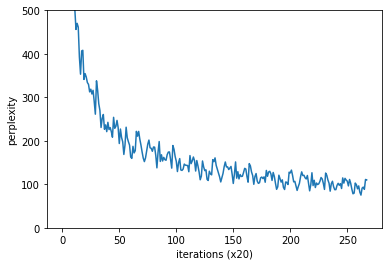

evaluating perplexity ...
234 / 235
테스트 퍼플렉서티:  136.3136962392949


In [7]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
import pickle


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

## 6.5 RNNLM 추가 개선

### 6.5.1 LSTM 계층 다양화
- RNNLM으로 정확한 모델을 만들고자 한다면 많은 경우 LSTM 계층을 깊게 쌓아 효과를 볼 수 있음

### 6.5.2 드롭아웃에 의한 과적합 억제
- 층을 깊게 쌓음으로써 표현력이 풍부한 모델을 만들 수 있지만 이런 모델은 종종 과적합 일으킴
- 정규화 normalization 사용
- 드롭아웃 dropout 사용
- 변형 드롭아웃을 통해 시간 방향으로 적용

### 6.5.3 가중치 공유
- 가중치 공유 weight trying
- 가중치를 공유함으로써 학습해야 할 매개변수 수를 줄일 수 있고, 그 결과 학습하기가 더 쉬워진다
- 매개변수가 줄어들기때문에 과적합이 억제된다

### 6.5.4 개선된 RNNLM 구현
- LSTM 계층의 다양화
- 드롭아웃 사용
- 가중치 공유

In [8]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.
     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 세가지 개선
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import sys
sys.path.append('..')
from common import config
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)